<a href="https://colab.research.google.com/github/RomadonaTanjungAT/Prediksi_Cuaca_PT_GGP/blob/main/Prediksi%20Cuaca%20PT%20GGP%20PG%204.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import library
import pandas as pd
import numpy as np
from numpy import array
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split #untuk membagi data
from keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow as tf
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error,  mean_absolute_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Dropout

#import data
data = pd.read_excel('/content/data cuaca harian GGP.xlsx') #memanggil data
df = pd.DataFrame(data) #mengubah data menjadi bentuk data frame
df_time = df["tanggal"]
df = df.drop(['tanggal'],axis=1)
df = df.drop(['WD'],axis=1)
print(df)

       RF     SM     ST   SEC    BLT    WS       AP     AT     AH   UV
0     0.0  25.51  28.70  31.0  24.08  0.00  1007.10  24.00  94.92  0.0
1     0.0  25.58  28.50  31.0  23.99  0.00  1006.30  23.60  94.92  0.0
2     0.0  25.66  28.38  31.0  23.92  0.00  1005.80  23.80  94.92  0.0
3     0.0  25.54  28.23  32.0  23.74  0.04  1005.58  23.60  94.92  0.0
4     0.0  25.54  28.16  31.0  24.11  0.11  1005.60  23.76  94.92  0.0
...   ...    ...    ...   ...    ...   ...      ...    ...    ...  ...
5827  0.0  26.94  29.50  79.0  26.30  1.03  1009.80  26.18  93.00  0.0
5828  0.0  26.98  29.46  79.0  25.00  0.08  1010.70  25.10  94.92  0.0
5829  0.0  26.89  29.40  79.0  24.48  0.07  1011.50  24.10  94.92  0.0
5830  0.0  26.94  29.30  80.0  23.92  0.03  1011.70  23.70  94.92  0.0
5831  0.0  26.88  29.21  79.0  23.73  0.08  1011.76  23.30  94.92  0.0

[5832 rows x 10 columns]


In [2]:
parameter = ['RF','SM','ST','SEC','BLT','WS','AP','AT','AH','UV']
for i in parameter :
  mean = df[i].mean()
  df[i] = df[i].replace(np.nan, mean)

#menyimpan data
data_fix = df
data_fix.to_excel('data harian menggunakan mean.xlsx', index=False)

indicator = ['RF','SM','ST','SEC','BLT','WS','AP','AT','AH','UV']
df = df[indicator]

In [3]:
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		if out_end_ix > len(sequences):
			break
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(data_fix)

total_dataset = len(data_fix)
df_train = df_scaled[:int(total_dataset*0.80)]
df_test = df_scaled[int(total_dataset*0.80):total_dataset]

print('Data for train:', df_train.shape)
print('Total hari for train:', round(df_train.shape[0]/24))
print('\nData for test:', df_test.shape)
print('Total hari for test:', round(df_test.shape[0]/24))

Data for train: (4665, 10)
Total hari for train: 194

Data for test: (1167, 10)
Total hari for test: 49


In [4]:
#Memilih angka timestep
n_steps_in, n_steps_out = 24,1
x_train, y_train = split_sequences(df_train, n_steps_in, n_steps_out)
x_test, y_test = split_sequences(df_test, n_steps_in, n_steps_out)
n_features = x_train.shape[2]

print('Data input structure for training',x_train[0])
print('\nData output structure for validation', y_test[0])

Data input structure for training [[0.00000000e+00 1.65964173e-01 1.61632465e-01 3.36538462e-02
  3.59773856e-02 0.00000000e+00 4.98845883e-01 3.41199886e-01
  5.01638305e-01 0.00000000e+00]
 [0.00000000e+00 1.67808219e-01 1.57020982e-01 3.36538462e-02
  3.44354977e-02 0.00000000e+00 4.98449620e-01 3.35513221e-01
  5.01638305e-01 0.00000000e+00]
 [0.00000000e+00 1.69915701e-01 1.54254093e-01 3.36538462e-02
  3.32362515e-02 0.00000000e+00 4.98201956e-01 3.38356554e-01
  5.01638305e-01 0.00000000e+00]
 [0.00000000e+00 1.66754478e-01 1.50795481e-01 3.84615385e-02
  3.01524756e-02 3.05810398e-03 4.98092983e-01 3.35513221e-01
  5.01638305e-01 0.00000000e+00]
 [0.00000000e+00 1.66754478e-01 1.49181462e-01 3.36538462e-02
  3.64913483e-02 8.40978593e-03 4.98102890e-01 3.37787887e-01
  5.01638305e-01 0.00000000e+00]
 [0.00000000e+00 1.67808219e-01 1.46414572e-01 3.84615385e-02
  2.89532294e-02 1.52905199e-03 4.98518966e-01 3.31248223e-01
  5.01638305e-01 0.00000000e+00]
 [0.00000000e+00 1.68335

In [5]:
tf.keras.backend.clear_session()
# define model
model = Sequential()
model.add(LSTM(100,activation='tanh',input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(100,activation='tanh', return_sequences=True))
model.add(TimeDistributed(Dense(n_features, activation='relu')))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               44400     
                                                                 
 repeat_vector (RepeatVecto  (None, 1, 100)            0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 1, 100)            80400     
                                                                 
 time_distributed (TimeDist  (None, 1, 10)             1010      
 ributed)                                                        
                                                                 
Total params: 125810 (491.45 KB)
Trainable params: 125810 (491.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
# fit mode
epoch = 100
learning_rate = 0.005
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mse',
              metrics=[tf.metrics.MeanAbsoluteError()])

history = model.fit(x_train, y_train, epochs=epoch, validation_data=(x_test, y_test))

Epoch 1/100
146/146 [==============================] - 14s 62ms/step - loss: 8.7010e-04 - mean_absolute_error: 0.0138 - val_loss: 7.8211e-04 - val_mean_absolute_error: 0.0141
Epoch 2/100
146/146 [==============================] - 6s 41ms/step - loss: 9.3020e-04 - mean_absolute_error: 0.0144 - val_loss: 0.0012 - val_mean_absolute_error: 0.0215
Epoch 3/100
146/146 [==============================] - 6s 42ms/step - loss: 0.0011 - mean_absolute_error: 0.0154 - val_loss: 7.8811e-04 - val_mean_absolute_error: 0.0137
Epoch 4/100
146/146 [==============================] - 7s 46ms/step - loss: 0.0010 - mean_absolute_error: 0.0148 - val_loss: 7.5968e-04 - val_mean_absolute_error: 0.0135
Epoch 5/100
146/146 [==============================] - 10s 66ms/step - loss: 8.5853e-04 - mean_absolute_error: 0.0134 - val_loss: 7.9859e-04 - val_mean_absolute_error: 0.0137
Epoch 6/100
146/146 [==============================] - 6s 38ms/step - loss: 8.4150e-04 - mean_absolute_error: 0.0134 - val_loss: 7.7705e-04 

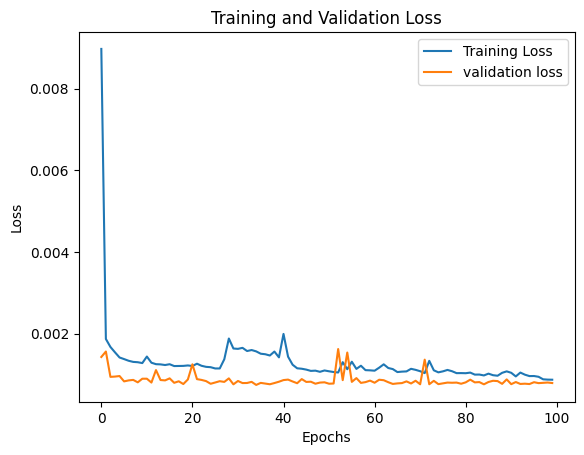

In [7]:
# Mendapatkan nilai kerugian dan metrik dari objek history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Membuat plot kurva kerugian
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [8]:
prediksi = model.predict(x_test)
print(prediksi.shape)
print(y_test.shape)

36/36 [==============================] - 2s 11ms/step
(1143, 1, 10)
(1143, 1, 10)


In [9]:
#reshape
prediksi = np.reshape(prediksi, (1143*1, 10))
real = np.reshape(y_test, (1143*1, 10))

# rescale
prediksi = pd.DataFrame(prediksi)
prediksi = scaler.inverse_transform(prediksi)
prediksi = pd.DataFrame(prediksi)
prediksi = prediksi.rename(columns={0: "RF", 1: "SM", 2: "ST",
                                          3: "SEC", 4: "BLT", 5: "WS",
                                          6:"AP", 7:"AT", 8:"AH", 9:"UV"})

real = pd.DataFrame(real)
real = scaler.inverse_transform(real)
real = pd.DataFrame(real)

print(prediksi.shape)
print(real.shape)

(1143, 10)
(1143, 10)


In [10]:
df_t = df_time[int(len(data_fix)*0.8) : ]
df_t1 = df_t[4:]
df_akhir = pd.DataFrame()

indicators = ['RF_LSTM','SM_LSTM','ST_LSTM','SEC_LSTM','BLT_LSTM','WS_LSTM','AP_LSTM','AT_LSTM','AH_LSTM','UV_LSTM']
m=-1
for i in indicator:
  m=m+1
  df_akhir[i] = real[m]
  df_akhir[indicators[m]] = prediksi[i]

df_akhir["waktu"] = df_akhir.RF
for i in range(0,len(df_akhir)):
   df_akhir.waktu.iloc[i] = df_t1.iloc[i]
df_akhir = df_akhir.set_index('waktu')
df_akhir

<ipython-input-10-1b243773ce7b>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_akhir.waktu.iloc[i] = df_t1.iloc[i]


,RF,RF_LSTM,SM,SM_LSTM,ST,ST_LSTM,SEC,SEC_LSTM,BLT,BLT_LSTM,WS,WS_LSTM,AP,AP_LSTM,AT,AT_LSTM,AH,AH_LSTM,UV,UV_LSTM
waktu,,,,,,,,,,,,,,,,,,,,
2023-06-13 13:00:00,0.0,0.0,24.30,24.341829,29.95,30.102337,66.0,64.404938,36.70,32.979111,1.35,0.725549,1011.60,1011.927979,29.00,28.320230,90.40,90.651939,1.47,1.600219
2023-06-13 14:00:00,0.0,0.0,19.40,24.354664,23.93,30.053387,52.8,64.607361,44.74,39.050957,1.62,1.461643,1011.22,1007.896912,30.40,30.431072,82.18,83.078445,2.79,2.640566
2023-06-13 15:00:00,0.0,0.0,24.26,23.930410,29.91,29.685120,66.0,64.797562,38.51,46.722069,1.28,1.587018,1010.78,1009.526489,30.62,31.928471,79.50,75.907761,2.55,2.894227
2023-06-13 16:00:00,0.0,0.0,19.44,24.836962,24.01,30.073353,52.8,64.663902,39.89,43.152668,1.10,1.392931,1009.90,1022.158386,31.50,32.978580,75.52,74.622765,3.05,5.534364
2023-06-13 17:00:00,0.0,0.0,24.30,24.956299,30.15,30.656532,66.0,68.228951,37.85,39.299431,0.96,1.537992,1009.26,1001.366699,31.84,31.894852,75.84,74.848541,2.00,3.836418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-30 23:00:00,0.0,0.0,26.94,26.771961,29.50,29.188171,79.0,80.501572,26.30,27.191181,1.03,1.803166,1009.80,1006.893005,26.18,26.709253,93.00,90.192566,0.00,0.000000
2023-07-31 00:00:00,0.0,0.0,26.98,26.816713,29.46,29.454252,79.0,79.271172,25.00,26.278225,0.08,0.866037,1010.70,1010.375793,25.10,25.833652,94.92,93.815712,0.00,0.000000
2023-07-31 01:00:00,0.0,0.0,26.89,26.677893,29.40,29.411022,79.0,77.215996,24.48,25.945118,0.07,0.371945,1011.50,1010.789795,24.10,25.447220,94.92,94.746887,0.00,0.000000


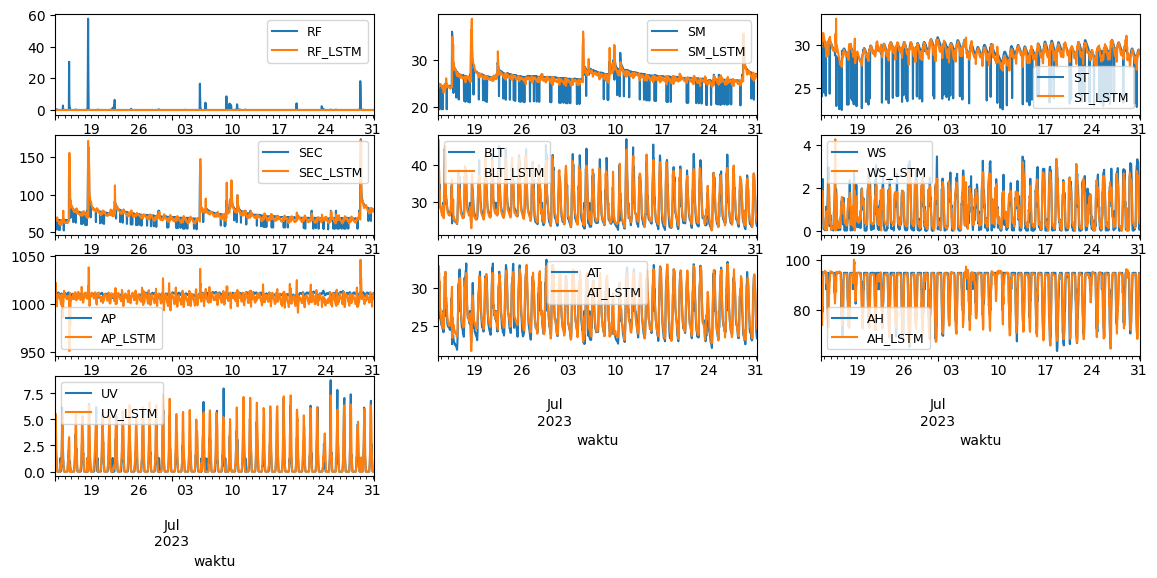

In [11]:
import matplotlib.pyplot as plt
import matplotlib as mpl

fig, axes = plt.subplots(4, 3, figsize=(14, 6))
fig = mpl.pyplot.gcf()
mpl.rcParams['axes.grid'] = False
plt.rcParams.update({
    "font.size": 9,
})

df_akhir[['RF','RF_LSTM']].plot(ax=axes[0, 0])
df_akhir[['SM', 'SM_LSTM']].plot(ax=axes[0, 1])
df_akhir[['ST', 'ST_LSTM']].plot(ax=axes[0, 2])
df_akhir[['SEC', 'SEC_LSTM']].plot(ax=axes[1, 0])
df_akhir[['BLT', 'BLT_LSTM']].plot(ax=axes[1, 1])
df_akhir[['WS', 'WS_LSTM']].plot(ax=axes[1, 2])
df_akhir[['AP', 'AP_LSTM']].plot(ax=axes[2, 0])
df_akhir[['AT', 'AT_LSTM']].plot(ax=axes[2, 1])
df_akhir[['AH', 'AH_LSTM']].plot(ax=axes[2, 2])
df_akhir[['UV', 'UV_LSTM']].plot(ax=axes[3, 0])

# Jika Anda hanya memiliki 7 variabel, maka subplot (1,3) tidak digunakan
# Hapus subplot (1,3)
fig.delaxes(axes[3, 1])
fig.delaxes(axes[3, 2])

plt.show()

In [16]:
data_prediksi = df_akhir
data_prediksi.to_excel('Hasil Prediksi Cuaca update.xlsx', index =True)

In [17]:
for i in indicator:
  rmse = mean_squared_error(df_akhir[f'{i}'],df_akhir[f'{i}_LSTM'], squared=False)
  print(f'{i} ----> RMSE: {rmse}\n')

RF ----> RMSE: 2.3641115149320417

SM ----> RMSE: 1.5146544752359927

ST ----> RMSE: 1.5312050186287272

SEC ----> RMSE: 6.940527677588223

BLT ----> RMSE: 2.0485150329043043

WS ----> RMSE: 0.42018611942690115

AP ----> RMSE: 6.29592788554758

AT ----> RMSE: 1.0276708567351058

AH ----> RMSE: 3.4629225141850113

UV ----> RMSE: 1.0823658687120952



In [ ]:
model.save_weights('./checkpoints/my_checkpoint')

In [ ]:

!mkdir -p saved_model
model.save('saved_model/my_model')
model.save('model_fix.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
